# Tutorial 5: Contact prediction and PDB comparison

This notebook contains examples of how to use the PyCom library to
1. Derive contact predictions from the CCMpred coevolution matrices in PyComDB
2. Parse and compare these to experimental PDB structures

For this it provides tooling for:
- Deriving contact matrix from PDB structures (if residue distance < 8 angstroms)
- Deriving predicted contact matrix from Protein Residue-Residue Contacts matrices (e.g., CCMPred, GREMLIN, etc.)
- Methods for manipulating and visualising contact matrices

This code may be useful if additional contact prediction methods are used, as to allow simple comparison between them.

## Settings:

In [1]:
IS_IN_CONTACT_THRESHOLD = 8  # max distance in angstroms, for residues to be considered in contact (default=8)

from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from pycom import CoMAnalysis, PyCom, pdb2res, pdb_analysis, util

In [2]:
# Some useful methods for later on

def contact_pred_from_coevolution(pd_df):
    """
    Takes in the output of PyCom#find, with a single row
    Returns a contact prediction matrix
    """
    assert len(pd_df) == 1, 'Only one matrix at a time'
    
    com_an = CoMAnalysis()
    com_an.add_contact_predictions(pd_df, contact_factor=1.5)
    
    return pd_df.iloc[0]['contact_matrix']

def align_matrices(n: np.ndarray, m: np.ndarray):
    """
    Aligns two matrices by padding the smaller one with -1
    """
    if n.shape[0] > m.shape[0]:
        m = util.format_util.embed_in_larger_matrix(m, n.shape[0], offset=0, value=-1)
    elif n.shape[0] < m.shape[0]:
        n = util.format_util.embed_in_larger_matrix(n, m.shape[0], offset=0, value=-1)
    return n, m

def get_seq_from_pdb(pdb_ent_gz_file: str) -> str:
    """Extract the sequence from a PDB file (missing residues are represented as '.')"""
    pdb_data = pdb2res.residues_from_pdb(pdb_ent_gz_file)[:, 0]
    sequence = reduce(lambda x, y: x+y, pdb_data)
    return sequence

def contact_accuracy_prec(pred: np.ndarray, ref: np.ndarray, ignore_n_adjacent: int = 0):
    """
    Calculates the sensitivity and precision of contact prediction between two contact maps.
    
    Sensitivity = % of correctly predicted contacts / % of contacts in reference
    Precision = % of correctly predicted contacts / % of contacts in prediction
    
    Inputs:
        pred: predicted contact map (e.g., from CCMPred)
        ref: reference contact map (e.g., from PDB)
        ignore_n_adjacent: number of adjacent residues to ignore (default=0)
            If 0, only self-contacts are ignored (set to -1 if self-contact should be counted)
    """
    p_mat = pred[np.tril_indices_from(pred, -1 - ignore_n_adjacent)]  # ignore self-contact by default
    gt_mat = ref[np.tril_indices_from(ref, -1 - ignore_n_adjacent)]
    known_ind = (p_mat != -1) & (gt_mat != -1)
    p_contact_ind = (p_mat[known_ind] == 1)
    gt_contact_ind = (gt_mat[known_ind] == 1)
    
    sensitivity = np.sum(p_contact_ind & gt_contact_ind) / np.sum(gt_contact_ind)
    precision = np.sum(p_contact_ind & gt_contact_ind) / np.sum(p_contact_ind)
    return sensitivity, precision

def display_subplot(matrix, text, no: int = 1, r=(-1, 1)):
        if r is None:  kwarg = {}
        else: kwarg = {'vmin': r[0], 'vmax': r[1]}
    
        plt.subplot(1, 2, no)
        plt.imshow(matrix, cmap='RdBu', **kwarg)
        plt.title(text)
        plt.axis('off')

## Load and display contact map from PyCom

We want to derive the predicted contact map from the data stored in CCMpred 

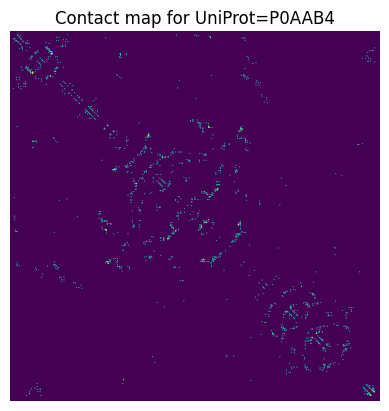

In [3]:
uniprot_id, pdb_id = 'P0AAB4', '5M1E'  # protein and associated PDB structure

# pull the Coevolution data from PyComDB
protein = PyCom(remote=True).find(uniprot_id=uniprot_id, page=1, matrix=True)
contact_map_prediction = contact_pred_from_coevolution(protein)

plt.axis('off')
plt.title(f'Contact map for UniProt={uniprot_id}')
_ = plt.imshow(contact_map_prediction)

## Loading contact and distance matrices from PDB structure

(491, 3) float64 [[    nan     nan     nan]
 [    nan     nan     nan]
 [    nan     nan     nan]
 ...
 [ 78.286 -51.921  19.995]
 [ 75.22  -52.773  14.654]
 [ 78.437 -49.061  13.272]]


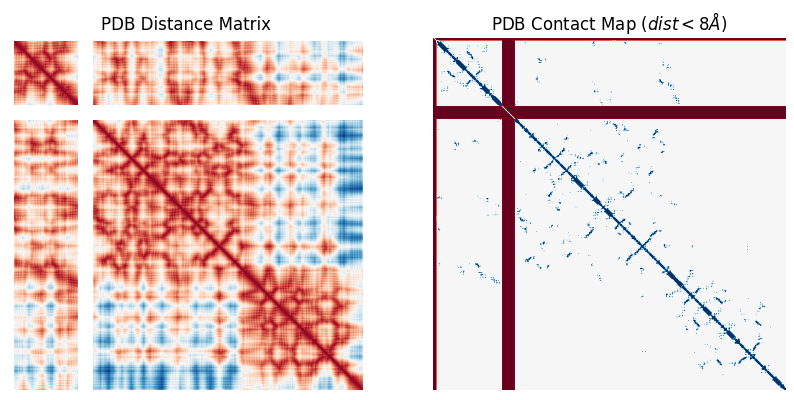

In [4]:
# example structure, download full PDB DB from: https://www.rcsb.org/pages/download/http or https://pycom.brunel.ac.uk/misc/
PDB_FILE = f'./toy_data/pdb{pdb_id.lower()}.ent.gz'

pdb_dist_mat = pdb_analysis.get_distance_matrix(PDB_FILE)
pdb_contact_map = pdb_analysis.get_contact_map(PDB_FILE, cutoff=IS_IN_CONTACT_THRESHOLD)

plt.figure(figsize=(10, 5))
display_subplot(pdb_dist_mat, "PDB Distance Matrix", no=1, r=None)
display_subplot(pdb_contact_map, "PDB Contact Map ($dist<8Å$)", no=2)
plt.show()


## Comparing Predicted Contacts to experimental structures

Having derived contact predictions from both the CCMPred matrices, and the PDB structures,
we can now compare them.

This implementation uses a naïve approach for calculating accuracy, which can be further refined.

Additionally, tweaking the `contact_factor` param when deriving predictions from coevolution matrices (by default, it makes 1.5 x L predictions)
or the `cutoff` (default=8 Angstrom) when deriving contact maps from PDB structures significantly changes the results. 

Tweaking `IGNORE_N_ADJACENT` also changes the accuracy significantly, by not considering residues in close proximity. 

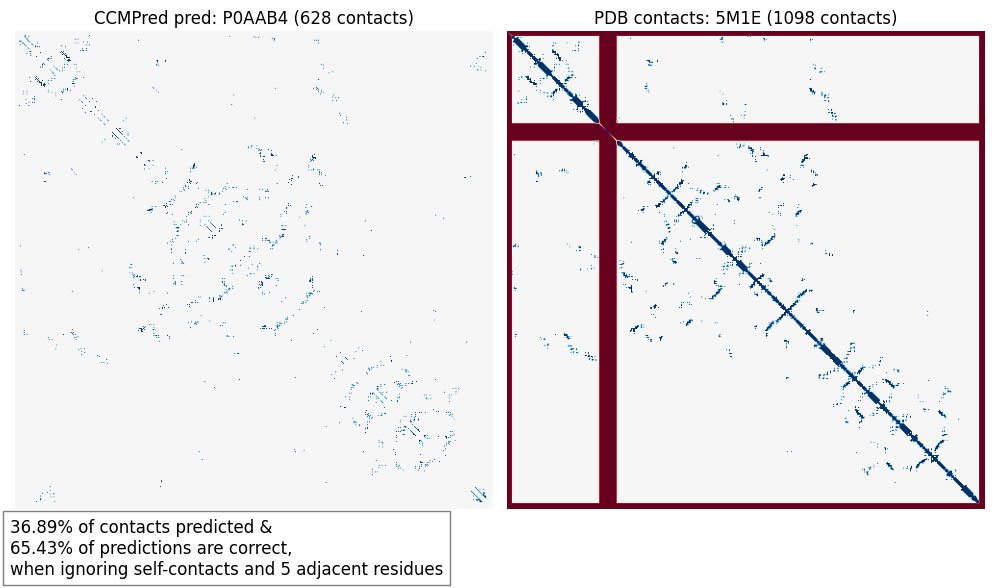

In [5]:
IGNORE_N_ADJACENT = 5  # ignore N adjacent residues, when calculating accuracy (default=5) (0=only self-contacts are ignored, 1=1 adjacent residue is ignored, etc.)

# Align contact maps, to enable broadcasting
contact_ccmpred, contact_pdb = align_matrices(contact_map_prediction, pdb_contact_map)

# Calculate the number of predictions made
# We only consider the lower triangle, as to now double count
cov_contact_predictions = sum(contact_ccmpred[np.tril_indices_from(contact_ccmpred, k=-1-IGNORE_N_ADJACENT)] == 1)
pdb_contact_predictions = sum(contact_pdb[np.tril_indices_from(contact_pdb, k=-1-IGNORE_N_ADJACENT)] == 1)

# We calculate the accuracy (naïve approach, accuracy function should be refined)
percent_of_contacts_predicted, percent_of_predicted_contacts_correct = contact_accuracy_prec(contact_ccmpred, contact_pdb, ignore_n_adjacent=IGNORE_N_ADJACENT)

plt.figure(figsize=(10, 6.2))
display_subplot(contact_ccmpred, f'CCMPred pred: {uniprot_id} ({cov_contact_predictions} contacts)', no=1)
display_subplot(contact_pdb, f'PDB contacts: {pdb_id} ({pdb_contact_predictions} contacts)', no=2)
plt.tight_layout()

plt.figtext(0.01, 0.01,
            f"{percent_of_contacts_predicted:.2%} of contacts predicted &\n"
            f"{percent_of_predicted_contacts_correct:.2%} of predictions are correct,\n"
            f"when ignoring self-contacts and {IGNORE_N_ADJACENT} adjacent residues",
            ha="left", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.show()